# Quick start for binary classification

Quick start for binary classification

In [ ]:
# bash generate_data_binary.sh

In [1]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats

import skimage.transform
from keras import models, layers, activations, optimizers, regularizers
from keras.utils import plot_model
from keras.models import load_model

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pymc3 # this will be removed
import pydot # optional

Using TensorFlow backend.


In [4]:
%run -i ImaGene.py

First iteration.

Read simulations and store them into object.

In [7]:
myfile = ImaFile(simulations_folder='/home/mfumagal/Data/ImaGene/Binary/Simulations1.Epoch3', nr_samples=128, model_name='Marth-3epoch-CEU')

In [8]:
mypop = myfile.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=100)

Have a look at the data and the allele frequency for the selected allele.

In [9]:
mypop.summary()

An object of 500 images
Rows: min 128, max 128, mean 128.000000, std 0.000000
Columns: min 124, max 418, mean 257.054000, std 54.047045


0

Text(0, 0.5, 'Allele frequency')

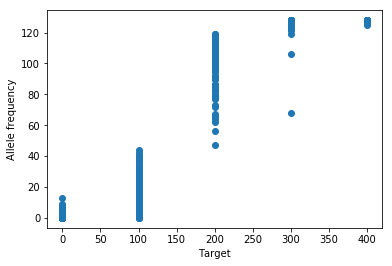

In [10]:
freqs = calculate_allele_frequency(mypop, 0.5)
plt.scatter(mypop.targets, freqs, marker='o')
plt.xlabel('Target')
plt.ylabel('Allele frequency')

Manipulate object to: major/minor polarisation, sort rows/cols, resize, convert to float.

In [11]:
mypop.majorminor()
mypop.filter_freq(0.01)
mypop.sort('rows_freq')
mypop.sort('cols_freq')
mypop.resize((128, 128))
mypop.convert(verbose=True)

Converting to numpy array.
Converting to float32.
Converting to [0,1].
Flipping values.
A numpy array with dimensions (500, 128, 128, 1) and 500 targets and 5 classes.


0

Plot one image per class as an illustration and check the new dimensions.

0


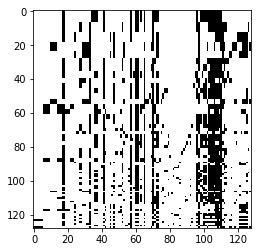

100


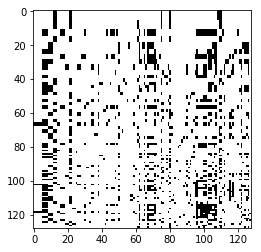

200


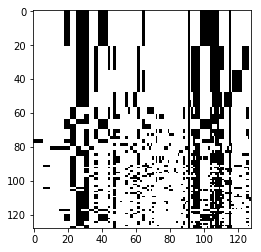

300


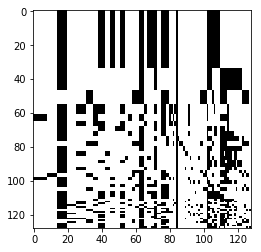

400


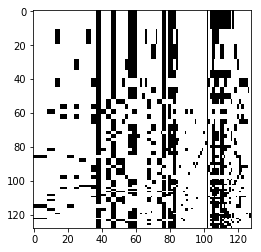

An object of 500 images
Rows: min 128, max 128, mean 128.000000, std 0.000000
Columns: min 128, max 128, mean 128.000000, std 0.000000


0

In [12]:
for sel in mypop.classes:
    print(sel)
    mypop.plot(np.where(mypop.targets == sel)[0][0])
mypop.summary()

Select only images corresponding to specified classes (e.g. 0 and 300) and check new dimensions.

In [13]:
mypop.classes = np.array([0,300])
classes_idx = get_index_classes(mypop.targets, mypop.classes)
len(classes_idx)

200

In [14]:
mypop.subset(classes_idx)
mypop.summary()

An object of 200 images
Rows: min 128, max 128, mean 128.000000, std 0.000000
Columns: min 128, max 128, mean 128.000000, std 0.000000


0

Randomly shuffle images.

In [15]:
rnd_idx = get_index_random(mypop)
mypop.subset(rnd_idx)

0

Convert targets to the appropriate format for keras (vectorise them).

In [16]:
mypop.targets = to_binary(mypop.targets)

The data is ready to be used for the classification.
You can save it.

In [19]:
# to save, create folder
os.mkdir('/home/mfumagal/Data/ImaGene/Binary/Images1.Epoch3')

In [20]:
mypop.save(file='/home/mfumagal/Data/ImaGene/Binary/Images1.Epoch3/mypop')

0

In [ ]:
# to load:
mypop = load_imagene(file='/home/mfumagal/Data/ImaGene/Binary/Images1.Epoch3/mypop')

Build the network and model.

In [22]:
mynet = ImaNet(name='[C32+P]x3+D64')

In [23]:
model = models.Sequential([
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid', input_shape=mypop.data.shape[1:4]),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Flatten(),
                    layers.Dense(units=64, activation='relu'),
                    layers.Dense(units=1, activation='sigmoid')])

In [24]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Summary of the model.

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
__________

In [28]:
plot_model(model, 'net.png')

Train the network.

In [29]:
score = model.fit(mypop.data, mypop.targets, batch_size=32, epochs=1, verbose=1, validation_split=0.10)

Train on 180 samples, validate on 20 samples
Epoch 1/1


InternalError: cudaGetDevice() failed. Status: CUDA driver version is insufficient for CUDA runtime version

In [ ]:
mynet.history = {}

In [ ]:
mynet.history.update(history.history)

In [ ]:
mynet.history

In [ ]:
mynet.model.save('net.h5')

In [ ]:
mynet.plot_train()

Iterate across all repetitions (i-th) and models (e-th, if relevant).
The first one initialises the model.
The last one is used for testing.

In [ ]:
import os
import gzip

import numpy as np
import scipy.stats

import skimage.transform
from keras import models, layers, activations, optimizers, regularizers
from keras.utils import plot_model
from keras.models import load_model

import matplotlib.pyplot as plt
import _pickle as pickle
from sklearn.metrics import confusion_matrix
import pymc3 # this will be removed
import pydot # optional

In [ ]:
%run -i ImaGene.py

In [ ]:
import pathlib

%run -i ImaGene.py
# get_ipython().run_line_magic('run', '-i /rds/general/user/mfumagal/home/Software/ImaGene/ImaGene.py')

for s in [100, 200, 300, 400]:

    for m in ['None', 'Rows', 'Cols', 'RowsCols']:

        for e in [1, 2, 3]:

            folder = '/home/mfumagal/Data/ImaGene/Binary/Results/Epoch' + str(e) + '/S' + str(s) + '/' + str(m)
            print(folder)
            pathlib.Path(folder).mkdir(parents=True, exist_ok=True) 
                       
            i = 0
            while i < 10:

                i += 1
                print(str(s) + str(m) + str(e) + str(i))

                myfile = ImaFile(simulations_folder='/home/mfumagal/Data/ImaGene/Binary/Simulations' + str(i) 
                         + '.Epoch' + str(e), nr_samples=128, model_name='Marth-' + str(e) + 'epoch-CEU')
                mypop = myfile.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=20)
    
                mypop.majorminor()
                mypop.filter_freq(0.01)
            
                if m == 'Rows':
                    mypop.sort('rows_freq')
                if m == 'Cols':
                    mypop.sort('cols_freq')
                if m == 'RowsCols':
                    mypop.sort('rows_freq')
                    mypop.sort('cols_freq')
                
                mypop.resize((128, 128))
                mypop.convert()
    
                mypop.classes = np.array([0,int(s)])
                classes_idx = get_index_classes(mypop.targets, mypop.classes)
                mypop.subset(classes_idx)
    
                rnd_idx = get_index_random(mypop)
                mypop.subset(rnd_idx)
    
                mypop.targets = to_binary(mypop.targets)
    
                if i == 1:
                    mynet = ImaNet(name='CPx2')
                    mynet.model = models.Sequential([
                        layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), padding='valid', input_shape=mypop.data.shape[1:4]),
                        layers.MaxPooling2D(pool_size=(2,2)),
                        #layers.Dropout(rate=0.5),
                        layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), padding='valid'),
                        layers.MaxPooling2D(pool_size=(2,2)),
                        #layers.Dropout(rate=0.5),
                        #layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid'),
                        #layers.MaxPooling2D(pool_size=(2,2)),
                        #layers.Dropout(rate=0.5),
                        layers.Flatten(),
                        layers.Dense(units=64, activation='relu'),
                        layers.Dense(units=1, activation='sigmoid')])
                    mynet.model.compile(optimizer='rmsprop',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
                    mynet.plot_net(summary=True, file=folder + '/net.png')
                else:
                    model = load_model(folder + '/net.h5')
    
                if i < 10:
                    score = mynet.model.fit(mypop.data, mypop.targets, batch_size=32, epochs=1, verbose=0, validation_split=0.10)
                    mynet.update_scores(score)
                    mynet.model.save(folder + '/net.h5')
                else:
                    mynet.test = mynet.model.evaluate(mypop.data, mypop.targets, batch_size=None, verbose=0)
                    print(mynet.test)

            # save the latest data (testing data)
            with open(folder + '/mypop','wb') as fp:
                pickle.dump(mypop, fp)
            # save the latest network
            with open(folder + '/mynet','wb') as fp:
                pickle.dump(mynet, fp)
        
            del mypop
            del mynet


Read results.

In [ ]:
for e in [1, 2, 3]:

    folder = '/home/mfumagal/Data/ImaGene/Binary/Results/Epoch' + str(e)
    
    with open(folder + '/mypop','rb') as fp:
        mypop = pickle.load(fp)

    with open(folder + '/mynet','rb') as fp:
        mynet = pickle.load(fp)
        
    

In [ ]:
e=3
s=300
m='RowsCols'

folder = '/home/mfumagal/Data/ImaGene/Binary/Results/Epoch' + str(e) + '/S' + str(s) + '/' + str(m)
    
with open(folder + '/mypop','rb') as fp:
    mypop = pickle.load(fp)

with open(folder + '/mynet','rb') as fp:
    mynet = pickle.load(fp)  


In [ ]:
mynet.test
mynet.plot_train()
mynet.plot_cm(mypop)
#mynet.plot_scatter(mypop)

In [ ]:
os.system('mkdir -p /home/mfumagal/Data/ImaGene/Binary/Results/Epoch3')

os.system('mv net.h5 /home/mfumagal/Data/ImaGene/Binary/Results/Epoch3/.')
os.system('mv net.png /home/mfumagal/Data/ImaGene/Binary/Results/Epoch3/.')

with open('/home/mfumagal/Data/ImaGene/Binary/Results/Epoch3/mypop','wb') as fp:
    pickle.dump(mypop, fp)
    
with open('/home/mfumagal/Data/ImaGene/Binary/Results/Epoch3/mynet','wb') as fp:
    pickle.dump(mynet, fp)

In [ ]:
os.system('mkdir -p /home/mfumagal/Data/ImaGene/Binary/Results/Epoch3')

In [ ]:
mynet.plot_train()

In [ ]:
mynet.plot_cm(mypop)

In [ ]:
mynet.plot_scatter(mypop)

In [ ]:
e = 1
folder = '/home/mfumagal/Data/ImaGene/Binary/Results/Epoch' + str(e)
print(folder)
subprocess.call(['mkdir -p', folder], shell=True)